# UV-Guider alignement with source in autocoll
##  Field 4

In [1]:
cd ../..

/Users/Vincent/Github/FireBallPipe


In [3]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
from astropy.io import fits
from astropy import wcs, coordinates
from astropy import units as u
from astropy.wcs.utils import proj_plane_pixel_scales
from matplotlib import pyplot as plt
from astropy.table import Table, vstack 
import matplotlib.patches as patches
import unittest
from mpl_interactions import heatmap_slicer
import pandas as pd
import datetime 
# os.chdir(os.path.dirname(os.path.realpath(__file__)))
sys.path.insert(1, './Calibration')
from guider2UV.guider2UV import Guider2UV, diff_skycoord, fit_model, plot_fit
from Calibration.mapping import Mapping

## initialization from last xy calib

In [33]:
G2UV = Guider2UV(filename='Notebook/2018/data_needed_to_run_notebooks/F4_180826.pkl')
print(G2UV)

FOV center angular position in guider <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39242605, 36.41307253)>): (lon, lat) in deg
    [(0.18305925, 0.00754495)]>
FOV center pixel position in guider [array([1366.30280082]), array([561.43593333])]

Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-90.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (36.9049, 0.65245)>)>
    gamma: 1.0

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39242605, 36.41307253)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.39242605  36.4130725262  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024526131524219  0.00024414585789761  
NAXIS : 0  0

    mask_rotation: 32.2732684991399

In [31]:
target_filename = 'Calibration/Targets/targets_F4.txt'
F4 = Table.read(target_filename, format='ascii')

## Diffuse UV image

load new mapping

In [32]:
mask_det_map_file = 'Notebook/2018/data_needed_to_run_notebooks/mapping-mask-det-180823-F4.pkl'
mask_det_map = Mapping(mask_det_map_file)
G2UV.set_detector_mapping(mask_det_map, offsets = [12.73 + 1., 1.57 + 1.])


## Scan sequence

GC - 31 - 40 - 44 - 33 - 12 - 6 - 8 - 13

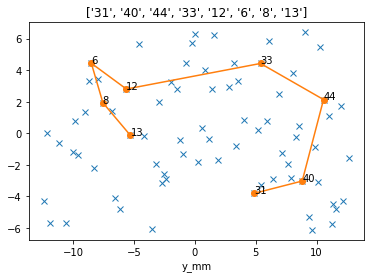

Internal-count,xmm,ymm,RA,DEC,ra_diff,dec_diff,angular_distance
str2,float64,float64,float64,float64,float64,float64,float64
31,4.853195,-3.812219,37.018761,0.56313,-335.025017828955,-66.26519999999982,341.5155037510473
40,8.811543,-3.028793,37.111828,0.581537,-148.53914863332398,-434.8008000000002,459.4731922075029
44,10.563193,2.136243,37.153091,0.702315,438.42906064049,-193.89600000000007,479.3909678228225
33,5.386155,4.42581,37.031296,0.756175,931.6708546945574,136.3644,941.597488885058
12,-5.638908,2.803272,36.772476,0.718296,243.67205013159796,-138.16079999999968,280.11510968167335
6,-8.51572,4.436704,36.704784,0.756674,-80.20820491944657,210.77999999999997,225.52508626846796
8,-7.570966,1.9379,36.727066,0.698124,-191.89095471158979,182.30039999999997,264.6801359004589
13,-5.303522,-0.138687,36.780373,0.647485,0.0,0.0,0.0
13,-5.303522,-0.138687,36.780373,0.647485,191.89294632706148,-182.30039999999997,264.6815798090991


In [10]:
slits = ['31', '40', '44', '33', '12', '6', '8', '13'] 
F1p = F1.to_pandas()
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# selected_slits = F1[mask.values]['Internal-count',"x_mm","y_mm","ra","dec"]
selected_slits = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1p[F1p['Internal-count'] == i],slits))))

ra,dec = "RA", "DEC"
x,y = "xmm","ymm"
plt.figure()
plt.plot(F1[x],F1[y],"x")
plt.plot(selected_slits[x],selected_slits[y],"-o")
for s in selected_slits:
    plt.text(s[x],s[y],s["Internal-count"])
plt.xlabel("x_mm")
plt.xlabel("y_mm")
plt.title(slits)
plt.show()

selected_slits = selected_slits['Internal-count',x,y,ra,dec]
slit_path = vstack((selected_slits,selected_slits[::-1]) )
# slit_path["ra_diff"] = [0] + list((slit_path[ra][1:] - slit_path[ra][:-1])*np.cos(slit_path[dec][:-1]*np.pi/180)) 
# slit_path["dec_diff"] = [0] + list((slit_path[dec][1:] - slit_path[dec][:-1])) 
slit_path["ra_diff"] = list((slit_path[ra][:-1] - slit_path[ra][1:])*np.cos(slit_path[dec][:-1]*np.pi/180)) + [0]
slit_path["dec_diff"] = list((slit_path[dec][:-1] - slit_path[dec][1:])) + [0]

slit_path["ra_diff"] *= 3600
slit_path["dec_diff"] *= 3600
slit_path["angular_distance"] = np.sqrt(slit_path["ra_diff"]** 2 + slit_path["dec_diff"]** 2)
try:
    slit_path.to_pandas().to_clipboard()
except Exception:
    pass
slit_path

In [13]:



# ici on balaye tout le champs
 
movs, flags, slits_coord = G2UV.compute_autocoll_moves_slits(slits, F4, hystcomp = True)
#donner les siderostat moves à Johan

slit position in mm on mask: [ 4.853195 -3.812219]
slit position in mm on mask: [ 8.811543 -3.028793]
slit position in mm on mask: [10.563193  2.136243]
slit position in mm on mask: [5.386155 4.42581 ]
slit position in mm on mask: [-5.638908  2.803272]
slit position in mm on mask: [-8.51572   4.436704]
slit position in mm on mask: [-7.570966  1.9379  ]
slit position in mm on mask: [-5.303522 -0.138687]

targets local coords in siderostat local frame:
EL: 168.3 arcsec ; CE: 189.2 arcsec
EL: 203.1 arcsec ; CE: 353.1 arcsec
EL: 423.3 arcsec ; CE: 423.8 arcsec
EL: 518.3 arcsec ; CE: 208.1 arcsec
EL: 445.0 arcsec ; CE: -247.8 arcsec
EL: 513.4 arcsec ; CE: -367.8 arcsec
EL: 407.5 arcsec ; CE: -327.5 arcsec
EL: 320.3 arcsec ; CE: -232.7 arcsec

siderostat moves sequence: 


In [14]:
movs.sum(axis=0)*3600

array([ 4.09272616e-10, -2.04636308e-10])

observed slits position :

In [15]:
slits_coord_obs_det = np.array([
       [1949.3159009 ,  585.48326732],
       [1889.08021255,  280.63274907],
       [1537.11743484,  151.33582687],
       [1393.47052805,  548.72769955],
       [1515.17137437, 1391.33183014],
       [1404.33980027, 1617.006362  ],
       [1573.20961616, 1543.30619621],
       [1713.61565248, 1366.89630183],
#return
       [1714.02190371, 1362.65367161],
       [1573.37446663, 1540.16005209],
       [1404.15691381, 1619.53755111],
       [1515.35044943, 1395.87784645],
       [1393.86272984,  553.35903851],
       [1536.87479529,  146.76319868],
       [1888.62954955,  276.27304535],
       [1949.00447949,  579.76363422]])


slits_coord_obs_det

array([[1949.3159009 ,  585.48326732],
       [1889.08021255,  280.63274907],
       [1537.11743484,  151.33582687],
       [1393.47052805,  548.72769955],
       [1515.17137437, 1391.33183014],
       [1404.33980027, 1617.006362  ],
       [1573.20961616, 1543.30619621],
       [1713.61565248, 1366.89630183],
       [1714.02190371, 1362.65367161],
       [1573.37446663, 1540.16005209],
       [1404.15691381, 1619.53755111],
       [1515.35044943, 1395.87784645],
       [1393.86272984,  553.35903851],
       [1536.87479529,  146.76319868],
       [1888.62954955,  276.27304535],
       [1949.00447949,  579.76363422]])

In [16]:
slits_coord_obs_det.shape

(16, 2)

In [17]:
valid = np.isfinite(slits_coord_obs_det[:,0])
#valid = np.array([True]*8 + [False]*8)
obs_wave = G2UV.mask_det_map.w[0]
print("wave: ", obs_wave)

slits_coord_valid = [slits_coord[i] for i in np.nonzero(valid)[0]]
slits_valid = np.array(slits + slits[::-1])[valid]

wave:  0.20255


In [18]:
slits_coord_valid

[<SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39242605, 36.41307253)>): (lon, lat) in deg
     [(0.09388028, -0.10820609)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39242605, 36.41307253)>): (lon, lat) in deg
     [(0.11325723, -0.20190289)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39242605, 36.41307253)>): (lon, lat) in deg
     [(0.23604675, -0.24236654)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39242605, 36.41307253)>): (lon, lat) in deg
     [(0.28905817, -0.11901337)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39242605, 36.41307253)>): (lon, lat) in deg
     [(0.2481774, 0.14167736)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39242605, 36.41307253)>):

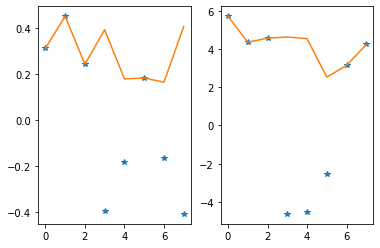

In [19]:
# analyser histeresis
mid  = len(slits_coord_obs_det)//2
pair_diff = slits_coord_obs_det[:mid] - slits_coord_obs_det[::-1][:mid]
pair_diff
fig, (ax0,ax1) = plt.subplots(1,2)
# ax0.subplot('120')
ax0.plot(pair_diff[:,0],'*')
ax0.plot(np.abs(pair_diff[:,0]),'-')
# plt.title("El pair diff")
# plt.ylabel("El arcsec")
# plt.subplot('121')
ax1.plot(pair_diff[:,1],'*')
ax1.plot(np.abs(pair_diff[:,1]),'-')
# plt.title("Ce pair diff")
# plt.ylabel("Ce arcsec")


In [20]:
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )


Fitting rotation, translation and magnification
gamma: 1.001987005843998
theta: 17.519586882348012 arcmin
dx: -5.6151381744169955 arcsec
dy: 5.3667749590642195 arcsec
variances: [3.70672132e-04 1.27427693e+00 3.74614573e-01 3.74614573e-01]

residuals in arcsec: [[-1.68433349  5.38995582]
 [-0.46739108  2.69934178]
 [ 1.21014636  1.60621335]
 [ 1.27522648 -2.07277262]
 [-0.04355511 -4.44682226]
 [-0.03725072 -0.51453834]
 [ 0.80603199  1.39747473]
 [-0.93078052  1.67528592]
 [-1.45460975 -3.02896277]
 [ 0.60676392 -2.11585494]
 [ 0.16884216  2.29084544]
 [-0.2699715   0.61384827]
 [ 0.8988432   3.08242029]
 [ 1.35647709 -3.45794099]
 [-0.02609162 -2.16989579]
 [-1.4083474  -0.94859791]]
max residual in EL,CE 1.7, 5.4 arcsec
mean residual in EL,CE 1.0, 2.7 arcsec


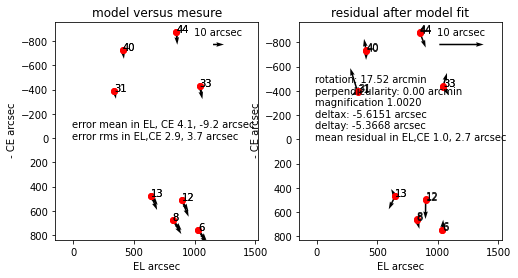

In [24]:
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)

G2UVcor,residuals = G2UV.update_model(slits_coord_valid, slits_coord_obs, labels=slits_valid, plot=True)

In [25]:
#G2UVcor.save(filename=cloudpath + 'TestsFTS2018-Flight/E2E-AIT-Flight/XYCalibration/F4_180904.pkl')

In [27]:
movs_new, flags, slits_coord_new = G2UVcor.compute_autocoll_moves_slits(slits, F4, hystcomp = True)

slit position in mm on mask: [ 4.853195 -3.812219]
slit position in mm on mask: [ 8.811543 -3.028793]
slit position in mm on mask: [10.563193  2.136243]
slit position in mm on mask: [5.386155 4.42581 ]
slit position in mm on mask: [-5.638908  2.803272]
slit position in mm on mask: [-8.51572   4.436704]
slit position in mm on mask: [-7.570966  1.9379  ]
slit position in mm on mask: [-5.303522 -0.138687]

targets local coords in siderostat local frame:
EL: 166.9 arcsec ; CE: 186.2 arcsec
EL: 202.5 arcsec ; CE: 350.2 arcsec
EL: 423.5 arcsec ; CE: 420.0 arcsec
EL: 517.7 arcsec ; CE: 203.4 arcsec
EL: 441.8 arcsec ; CE: -253.1 arcsec
EL: 509.7 arcsec ; CE: -373.7 arcsec
EL: 403.8 arcsec ; CE: -332.8 arcsec
EL: 316.9 arcsec ; CE: -237.4 arcsec

siderostat moves sequence: 


In [29]:
CEg, Elg = 1.02928, 1.00379
from astropy.table import hstack
moves=movs_new
moves = Table.from_pandas(pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"]))


moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]
moves["UV_image"] = moves["UV_image"].astype(bool)
new_cat = hstack((slit_path,moves[moves["UV_image"]][1:-1]))
new_cat
new_cat["EL_moves"] =  list(new_cat["EL_abs"][1:] - new_cat["EL_abs"][:-1]) +  [0]
new_cat["CE_moves"] =  list(new_cat["CE_abs"][1:] - new_cat["CE_abs"][:-1]) +  [0]



new_cat["El_sky"] = new_cat["EL_moves"]  * 2 * Elg 
new_cat["Cel_sky"] = new_cat["CE_moves"] * 2 * CEg 
new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# new_cat
new_cat.to_pandas().to_clipboard()
new_cat["ra_diff","dec_diff","EL_moves","CE_moves","El_sky","Cel_sky","frame_divided_sky","EL_dec_ratio","CE_ra_ratio"]


/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_43766/799231450.py:20: RuntimeWarning: invalid value encountered in true_divide
  new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_43766/799231450.py:21: RuntimeWarning: invalid value encountered in true_divide
  new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_43766/799231450.py:22: RuntimeWarning: invalid value encountered in true_divide
  new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]


ra_diff,dec_diff,EL_moves,CE_moves,El_sky,Cel_sky,frame_divided_sky,EL_dec_ratio,CE_ra_ratio
float64,float64,float64,float64,float64,float64,float64,float64,float64
-335.025017828955,-66.26519999999982,35.67541990978583,164.01694382282807,71.62125950248783,337.6387198759209,1.0106464470959282,-1.0808276365647131,-1.0078015130449163
-148.53914863332398,-434.8008000000002,221.00516304132498,69.81021674927769,443.6855452185032,143.70851979139306,1.015028975130263,-1.0204340590415266,-0.9674790862450979
438.42906064049,-193.89600000000007,94.12432021091126,-216.63176611033256,188.96210276902124,-445.94948844408617,1.0103071881211574,-0.9745538988376303,-1.017153123455388
931.6708546945574,136.3644,-75.84360033345257,-456.45740117929734,-152.2620951574327,-939.6449477716543,1.0109430651665223,-1.1165824449594814,-1.00855891652821
243.67205013159796,-138.16079999999968,67.86045407168422,-120.61493547509994,136.2352903852318,-248.29308157162174,1.0110587507850108,-0.9860632710959412,-1.0189641423278877
-80.20820491944657,210.77999999999997,-105.83970033638172,40.876986286322335,-212.4816656013132,84.14772888957171,1.0133564561490098,-1.0080731834202166,-1.0491162216394396
-191.89095471158979,182.30039999999997,-86.96656272549677,95.4582401068825,-174.5923319964528,196.50651475442405,0.9931370110282448,-0.9577177669190678,-1.0240530360056388
0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,nan
191.89294632706148,-182.30039999999997,86.96656272549677,-95.4582401068825,174.5923319964528,-196.50651475442405,0.9931315932008606,-0.9577177669190678,-1.02404240758021


## Star sequence

gc - s18 - s29 - s34 - s14 

In [24]:
star_target_path = cloudpath + 'Target_selection/GuidingStars/'

F4_stars = Table.read(star_target_path + "F4_guidingstars.fits", format='fits')

stars = [29, 34, 18, 14]

star_movs, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F4_stars, hystcomp = True)


star position Ra/Dec:  <SkyCoord (ICRS): (ra, dec) in deg
    [(36.987137, 0.402799)]>
star position Ra/Dec:  <SkyCoord (ICRS): (ra, dec) in deg
    [(37.023638, 0.390844)]>
star position Ra/Dec:  <SkyCoord (ICRS): (ra, dec) in deg
    [(36.877561, 0.53311)]>
star position Ra/Dec:  <SkyCoord (ICRS): (ra, dec) in deg
    [(36.867454, 0.492628)]>

targets local coords in siderostat local frame:
EL: -119.5 arcsec ; CE: 132.7 arcsec
EL: -140.0 arcsec ; CE: 196.8 arcsec
EL: 111.3 arcsec ; CE: -62.2 arcsec
EL: 38.5 arcsec ; CE: -78.9 arcsec

siderostat moves sequence: 
EL: 0.0 arcsec ; CE -30.0 arcsec ; image: False
EL: -0.0 arcsec ; CE 30.0 arcsec ; image: True
EL: -119.5 arcsec ; CE 132.7 arcsec ; image: True
EL: -20.5 arcsec ; CE 64.1 arcsec ; image: True
EL: 251.3 arcsec ; CE -259.1 arcsec ; image: True
EL: -72.9 arcsec ; CE -16.6 arcsec ; image: True
EL: 0.0 arcsec ; CE -30.0 arcsec ; image: False
EL: -0.0 arcsec ; CE 30.0 arcsec ; image: True
EL: 72.9 arcsec ; CE 16.6 arcsec ; image: T

In [ ]:
stars_coord

------------------------------------------------------